# Test decoupled plane-based registration

In [3]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import os

import planeslam.io as io
from planeslam.general import plot_3D_setup
from planeslam.registration import extract_corresponding_features

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Test with two planes

In [4]:
from planeslam.geometry.plane import BoundedPlane
from planeslam.registration import expmap
from planeslam.scan import Scan
import copy

V1 = np.array([[-1, 1, -1],
              [1, 1, -1],
              [1, 1, 1],
              [-1, 1, 1]])
V2 = np.array([[-1, -1, -1],
              [-1, 1, -1],
              [-1, 1, 1],
              [-1, -1, 1]])
P = Scan([BoundedPlane(V1), BoundedPlane(V2)])

# Ground-truth transformation
t = np.array([0, -0.5, 0])[:,None]
u = np.array([0, 1, 0])[:,None]
theta = np.pi/12
q = np.vstack((t, theta*u))

R = expmap(q[3:].flatten())

print("t: ", t)
print("R: ", R)

vertex and face generation not yet implemented
t:  [[ 0. ]
 [-0.5]
 [ 0. ]]
R:  [[ 0.96592583  0.          0.25881905]
 [ 0.          1.          0.        ]
 [-0.25881905  0.          0.96592583]]


In [5]:
# P is source, Q is target
Q = copy.deepcopy(P)
Q.transform(R, t.flatten())

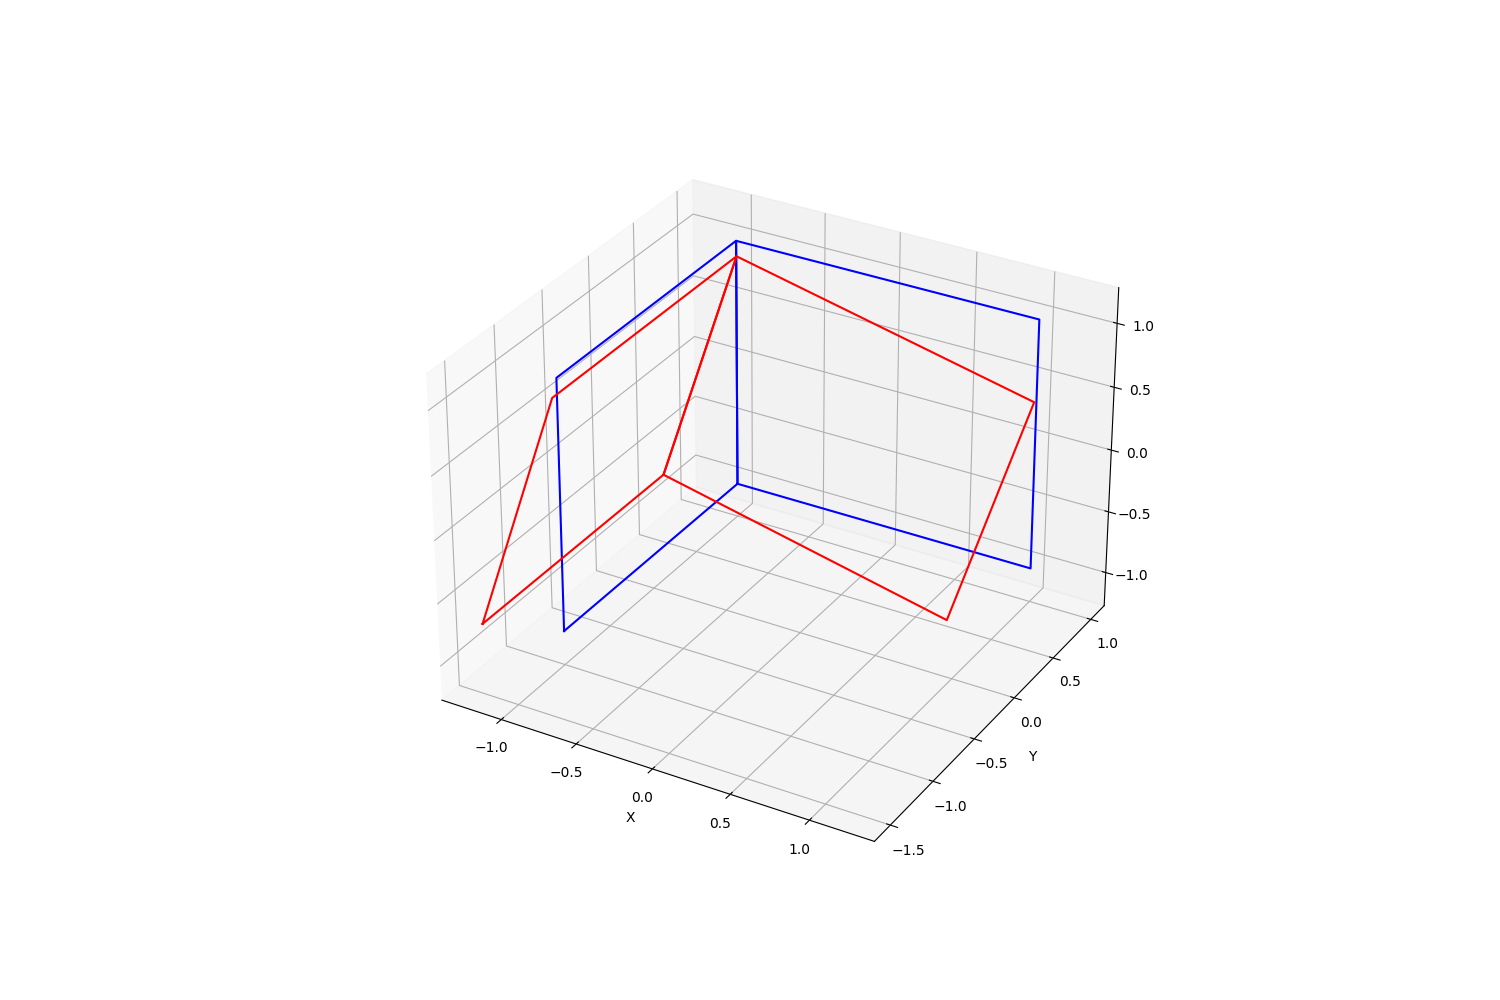

In [6]:
ax = plot_3D_setup()
P.plot(ax, color='b')
Q.plot(ax, color='r')

In [7]:
correspondences = [(0,0), (1,1)]
n_s, d_s, n_t, d_t = extract_corresponding_features(P, Q, correspondences)

In [20]:
n_t

array([[ 0.        ],
       [-1.        ],
       [ 0.        ],
       [ 0.96592583],
       [ 0.        ],
       [-0.25881905]])

In [19]:
np.reshape(n_t, (-1,3))

array([[ 0.        , -1.        ,  0.        ],
       [ 0.96592583,  0.        , -0.25881905]])

Estimate rotation

In [10]:
H = n_s[:3] @ n_t[:3].T + n_s[3:] @ n_t[3:].T
u, s, v = np.linalg.svd(H)
R_hat = u @ v

Estimate translation

In [27]:
A = np.reshape(n_t, (-1,3))
b = d_t - d_s
t_hat = np.linalg.lstsq(A, b, rcond=None)[0]